<a href="https://colab.research.google.com/github/gmflau/gen-ai/blob/main/Gemini_multi_modal_RAG_Redis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal LLM using Google's Gemini model for image understanding and build Retrieval Augmented Generation with LlamaIndex and Redis

In this notebook, we show how to use Google's Gemini Vision models for image understanding.

First, we show the use of gemini-pro-vision LLM to understand an image:
* `complete`: for a single prompt for an image

For the 2nd part of this notebook, we try to use `Gemini` + `Pydantic` to parse structured information for images from Google Maps.
* Define the desired Pydantic class with attribution fields
* Let `gemini-pro-vision` model understand each image and output structured results

For the the 3rd part of this notebook, we propose using Gemini & LlamaIndex to build a simple `Retrieval Augmented Generation` Flow for a small Google Maps restaurant dataset.
* Build vector index based on the structured outputs from Step 2
* Using the `gemini-pro` model to synthesize the results and recommends restaurants based on user query.

Note: `google-generativeai` is only available for certain countries and regions.

In [ ]:
%pip install llama-index-multi-modal-llms-gemini llama-index-embeddings-gemini llama-index-llms-gemini redis llama-index-vector-stores-redis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.0/631.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 13.3 MB/s eta 0:00:00


##  Use Gemini to understand Images from URLs

In [ ]:
import os
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_AI_STUDIO')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Initialize `GeminiMultiModal` and Load Images from URLs

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://storage.googleapis.com/generativeai-downloads/data/scene.jpg",
    # Add yours here!
]

image_documents = load_image_urls(image_urls)

gemini_pro = GeminiMultiModal(model_name="models/gemini-pro-vision")

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt.zip.


https://storage.googleapis.com/generativeai-downloads/data/scene.jpg


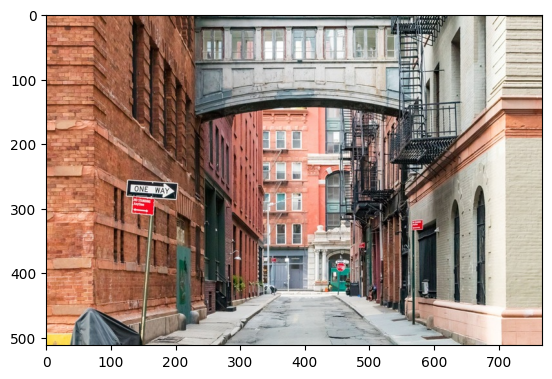

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

### Complete a prompt with a bunch of images

In [ ]:
complete_response = gemini_pro.complete(
    prompt="Identify the city where this photo was taken.",
    image_documents=image_documents,
)

In [ ]:
print(complete_response)

 New York City


### Stream Complete a prompt with a bunch of images

In [ ]:
stream_complete_response = gemini_pro.stream_complete(
    prompt="Give me more context for this image",
    image_documents=image_documents,
)

In [ ]:
for r in stream_complete_response:
    print(r.text, end="")

 This is an alleyway in New York City. It is a narrow street that is located between two buildings. The buildings are made of brick and are several stories tall. There is a bridge that connects the two buildings at the top of the alleyway. The bridge is made of metal and has a glass roof. There is a street sign on the left side of the alleyway that says "One Way". There is a black garbage can on the right side of the alleyway. The alleyway is empty except for a few parked cars.

## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

In [ ]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

List available Gemini Models from `google.generativeai`.
Make sure your API key has access to belowing models

In [ ]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-pro
models/gemini-pro-vision


### Download example images for Gemini to understand

In [ ]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg" -O ./google_restaurants/miami.png
!wget "https://docs.google.com/uc?export=download&id=1dYZy17bD6pSsEyACXx9fRMNx93ok-kTJ" -O ./google_restaurants/orlando.png
!wget "https://docs.google.com/uc?export=download&id=1ShPnYVc1iL_TA1t7ErCFEAHT74-qvMrn" -O ./google_restaurants/sf.png
!wget "https://docs.google.com/uc?export=download&id=1WjISWnatHjwL4z5VD_9o09ORWhRJuYqm" -O ./google_restaurants/toronto.png
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1wxTn0BHTKFomd53KK5MGmoeWblaLi9du" -O ./google_restaurants/beverly_hills.png

--2024-02-17 23:40:30--  https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg
Resolving docs.google.com (docs.google.com)... 172.217.12.14, 2607:f8b0:4025:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.12.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg&export=download [following]
--2024-02-17 23:40:30--  https://drive.usercontent.google.com/download?id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.164.1, 2607:f8b0:4025:803::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.164.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1800953 (1.7M) [image/png]
Saving to: ‘./google_restaurants/miami.png’

./google_restaurant 100%[===================>]   1.72M  --.-KB/s    in 0.1s    



### Define the Pydantic Class for the Structured Parser

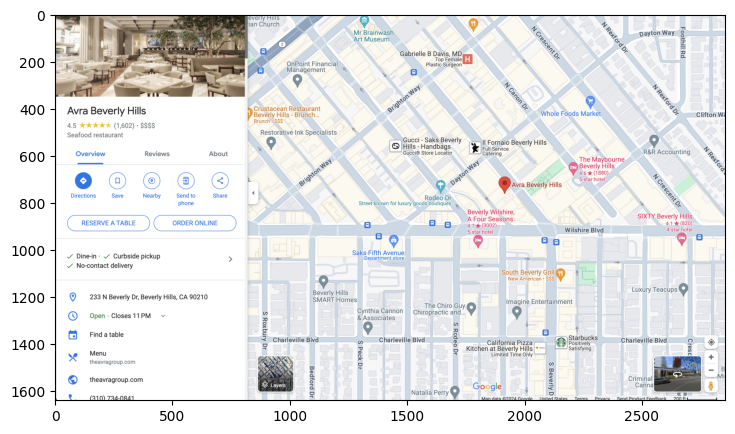

In [ ]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./google_restaurants/beverly_hills.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Call the Pydantic Program and Generate Structured Output

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [ ]:
from llama_index.core import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

> Raw output:  ```json
{
 "restaurant": "Ava Beverly Hills",
 "food": "Seafood",
 "location": "233 N Beverly Dr, Beverly Hills, CA 90210",
 "category": "Restaurant",
 "hours": "Open ⋅ Closes 11 PM",
 "price": "$$$$",
 "rating": 4.5,
 "review": "1,602",
 "description": "Upscale seafood restaurant featuring seasonal American fare in a chic, modern space with a full bar.",
 "nearby_tourist_places": "Rodeo Drive, a street known for luxury goods boutiques."
}
```
> Raw output:  ```json
{
 "restaurant": "La Mar by Gaston Acurio",
 "food": "South American",
 "location": "500 Brickell Key Dr, Miami, FL 33131",
 "category": "Restaurant",
 "hours": "Closes at 11 PM",
 "price": "Moderate",
 "rating": 4.4,
 "review": "4.4 (2,104)",
 "description": "Chic waterfront find offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticucho.",
 "nearby_tourist_places": "Brickell Key Park"
}
```
('restaurant', 'La Mar by Gaston Acurio')
('food', 'South American')
('location', '500 Brickell Key

`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps`

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [ ]:
from llama_index.core.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [ ]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes


deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


gpg: cannot open '/dev/tty': No such device or address
curl: (23) Failed writing body


In [ ]:
import redis
import os

REDIS_HOST = os.getenv("REDIS_HOST", "localhost")
REDIS_PORT = os.getenv("REDIS_PORT", "6379")
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "")

#shortcut for redis-cli $REDIS_CONN command
if REDIS_PASSWORD!="":
  os.environ["REDIS_CONN"]=f"-h {REDIS_HOST} -p {REDIS_PORT} -a {REDIS_PASSWORD} --no-auth-warning"
else:
  os.environ["REDIS_CONN"]=f"-h {REDIS_HOST} -p {REDIS_PORT}"

REDIS_URL = f"redis://:{REDIS_PASSWORD}@{REDIS_HOST}:{REDIS_PORT}"
print(REDIS_URL)

redis://:@localhost:6379


In [ ]:
from llama_index.vector_stores.redis import RedisVectorStore

print(f"Using Redis address: {REDIS_URL}")
redis_vector_store = RedisVectorStore(
    index_name="news",
    index_prefix="cnn",
    redis_url=REDIS_URL,
    overwrite=True
)
redis_vector_store.client.ping()

Using Redis address: redis://:@localhost:6379


True

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings
from llama_index.core import StorageContext

# Create a local Qdrant vector store
#client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

#vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
Settings.llm = Gemini(api_key=GOOGLE_API_KEY)

storage_context = StorageContext.from_defaults(vector_store=redis_vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Los Angeles restaurant for me and its nearby tourist places"
)
print(response)

Ava Beverly Hills is a recommended restaurant in Los Angeles. It is an upscale seafood restaurant featuring seasonal American fare in a chic, modern space with a full bar. Nearby tourist places include Rodeo Drive, a street known for luxury goods boutiques.
